In [22]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import string
import joblib

In [23]:
data = pd.read_csv("../csv_file/big_data.csv") 

In [24]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Download spaCy model
spacy.cli.download("en_core_web_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\soder\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\soder\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\soder\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [25]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm')

In [28]:
def count_words(text):
    tokens = nlp(text)
    return len(tokens)

In [13]:
def preprocess_text(text, use_lemmatization=True):
    # Lowercasing
    text = text.lower()
    
    # Tokenization using spaCy
    tokens = nlp(text)
    tokens = [token.text for token in tokens]
    
    # Punctuation Removal
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Stop Word Removal
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Lemmatization (optional)
    if use_lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

In [18]:
data['processed_text'] = data['headlines'].apply(preprocess_text)

In [19]:
max_features_value = 10000

In [20]:
tfidf_vectorizer = TfidfVectorizer(max_features=max_features_value)

In [22]:
X_tfidf = tfidf_vectorizer.fit_transform(data['processed_text'].apply(lambda x: ' '.join(x)))

In [23]:
# Split the data into training and testing sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, data['outcome'], test_size=0.2, random_state=42)

In [30]:
param_grid = {
    'C': [0.1, 1, 10, 100],      
    'kernel': ['linear', 'rbf'],   
    'gamma': [0.01, 0.1, 1, 'auto']
}

In [31]:
svm_model = SVC()  

In [32]:
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')

In [33]:
grid_search.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 1, 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [34]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [35]:
best_svm_model = grid_search.best_estimator_

In [36]:
y_pred_best = best_svm_model.predict(X_test_tfidf)

In [37]:
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Best Model Accuracy: {accuracy_best}')

Best Model Accuracy: 0.9279693486590038


joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')
joblib.dump(best_svm_model, 'svm_model.joblib')

Text(0.5, 1.0, 'Confusion Matrix')

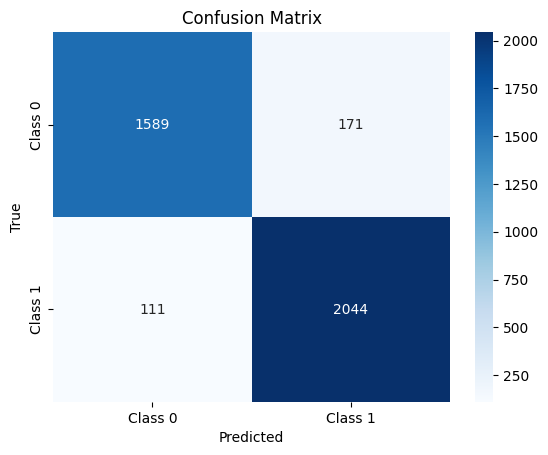

In [41]:
conf_matrix = confusion_matrix(y_test, y_pred_best)

# Create a heatmap of the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

In [7]:
loaded_tfidf_vectorizer = joblib.load('../trained_models_and_preprocessing pipeline/svm_model/tfidf_vectorizer.joblib')
loaded_svm_model = joblib.load('../trained_models_and_preprocessing pipeline/svm_model/svm_model.joblib')

In [155]:
test_data = pd.read_csv("../csv_file/test_data.csv") 

In [21]:
X = test_data["headlines"]
y = test_data["outcome"]

In [22]:
processed_text = [preprocess_text(x) for x in X]

In [24]:
processed_text_strings = [' '.join(text) for text in processed_text]

In [25]:
tfidf_features = loaded_tfidf_vectorizer.transform(processed_text_strings)

In [26]:
predictions = loaded_svm_model.predict(tfidf_features)

In [27]:
accuracy = accuracy_score(y, predictions)

In [28]:
print(accuracy)

0.895


In [29]:
threshold = 0.5

In [30]:
binary_predictions = (predictions >= threshold).astype(int)

In [38]:
for index, title in enumerate(X):
    prediction = binary_predictions[index]
    outcome = y.iloc[index]
    
    if outcome == 1:
        outcome = "Fake"
    else:
        outcome = "Real"
        
    if prediction == 1:
        prediction = "Fake"
    else:
        prediction = "Real"
    print(f"Title: {title}")
    print(f"Real Outcome: {outcome}")
    print(f"Prediction: {prediction}")
    print("=" * 50)

Title: CDC has given more than $200M to address #COVID19 health disparities among American Indian &amp; Alaska Native people who have suffered a disproportionate burden of illness. Funding will broaden access to COVID-19 resources across tribal communities. https://t.co/MG8e5TWigl https://t.co/KwoPLuxG4g
Real Outcome: Real
Prediction: Real
Title: #IndiaFightsCorona TEST TRACK TREAT- effective implementation by the Centre and States/UTs has ensured that India has one of lowest #COVID19 cases and deaths per million population compared to several other countries. https://t.co/Caqhv0M0rK
Real Outcome: Real
Prediction: Real
Title: Ireland's entire cabinet will "restrict their movements" after the health minister felt unwell and was tested for #coronavirus it has been reported https://t.co/i5zO9bFugY
Real Outcome: Real
Prediction: Fake
Title: The Chairman of the Republican Party of Texas said the recovery rate for COVID-19 is 99.9% in Texas. That’s False. @PolitiFactTexas https://t.co/GmUXoV

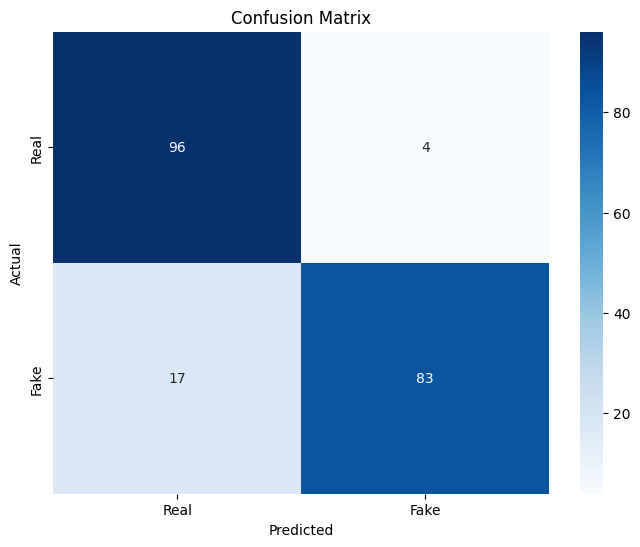

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90       100
           1       0.95      0.83      0.89       100

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.89       200
weighted avg       0.90      0.90      0.89       200



In [34]:
cm = confusion_matrix(y, binary_predictions)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report
print("Classification Report:\n", classification_report(y, binary_predictions))